# Excercise 2: Customization and Visualization #

The goal of this excercise is to change the wing shape, by creating a cutout for a wing flap. It should be done as follows

 - Get the existing wing shape from TiGL
 - Create a Box
 - Use the Box to cut away the wing using Boolean Operations
 - Visualize everything
 - Export the confguration and check, if the cutout is part of the aircraft

In the end, it should look similar to the following image:

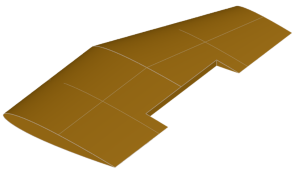

## Loading the modules ##

As usual, load the required TiGL and TiXI modules


In [1]:
from tixi3 import tixi3wrapper
from tigl3 import tigl3wrapper
import tigl3.configuration

Again open a the CPACS file simpletest.xml using the "old" high-level python API.

In [4]:
tixi_handle = tixi3wrapper.Tixi3()
tigl_handle = tigl3wrapper.Tigl3()

tixi_handle.open("../../cpacs/simpletest.cpacs.xml")
tigl_handle.open(tixi_handle, "")

## Accessing wing with UID Manager ##
Get the configuration manager from tigl3.configuration and retrieve the aircraft configuration first.

This time, use the UID Manager from the aircraft configuration, to access the wing.

In [5]:
config_mgr = tigl3.configuration.CCPACSConfigurationManager_get_instance()
aircraft_config = config_mgr.get_configuration(tigl_handle._handle.value)
uid_mgr = aircraft_config.get_uidmanager()
wing = uid_mgr.get_geometric_component("Wing")

## Create a box as a cutting tool ##

Use the BRepPrimAPI_MakeBox command to create the box. What size do you need?

In [6]:
from OCC.BRepPrimAPI import BRepPrimAPI_MakeBox
box = BRepPrimAPI_MakeBox(0.3, 0.8, 0.3).Solid()

- Figure out, which methods the transformation class offers
- Now move the box to the trailing edge of the wing. Use ```CTiglTransformation``` from tigl3.geometry to do it.


In [7]:
from tigl3.geometry import CTiglTransformation
help(CTiglTransformation)

trafo = CTiglTransformation()
trafo.add_translation(0.8, 0.6, -0.15)

moved_box = trafo.transform(box)

Help on class CTiglTransformation in module tigl3.geometry:

class CTiglTransformation(builtins.object)
 |  C++ includes: CTiglTransformation.h
 |  
 |  Methods defined here:
 |  
 |  Set(self, arg2)
 |      Set(CTiglTransformation self, CTiglTransformation arg2) -> CTiglTransformation
 |      
 |      Parameters
 |      ----------
 |      arg2: tigl::CTiglTransformation const &
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      __init__(tigl::CTiglTransformation self) -> CTiglTransformation
 |      __init__(tigl::CTiglTransformation self, gp_GTrsf const & ocMatrix) -> CTiglTransformation
 |      
 |      Parameters
 |      ----------
 |      ocMatrix: gp_GTrsf const &
 |      
 |      __init__(tigl::CTiglTransformation self, gp_Trsf const & trans) -> CTiglTransformation
 |      
 |      Parameters
 |      ----------
 |      trans: gp_Trsf const &
 |      
 |      __init__(tigl::CTiglTransformation self, gp_Vec const & translation

 - Create a named shape of the box, which is still of type TopoDS_Shape
 - Reminder: CNamedShape is the class you are looking for

In [8]:
from tigl3.geometry import CNamedShape
namedBox = CNamedShape(moved_box, "CutOut")

## Create the wing cutout ##

Use class ```CCutShape``` from ```tigl3.boolean_ops``` to create the wing cutout.

 1. Create the cutting tool
 2. Get the resulting shape from the cutter using the ```named_shape()``` method

In [9]:
from tigl3.boolean_ops import CCutShape
# cut the box from the wing
cutter = CCutShape(wing.get_loft(), namedBox)
cutted_wing_shape = cutter.named_shape()

## Apply the resulting shape to the wing component ##

The new wing shape has to be put back into the wing component. This way, it will be available for the exports.

Use the ```.Set(shape)``` method of the wing loft!

In [10]:
wing.get_loft().Set(cutted_wing_shape)

<tigl3.geometry.CNamedShape; proxy of <Swig Object of type 'PNamedShape *' at 0x000001A9A2B47540> >

## Exporting the result ##
Lets export the __fused aircraft__ to a _\*.stp_ STEP file and open the file in TiGL Viewer. Does it look as expected?

In [11]:
tigl_handle.setExportOptions("stp", "IncludeFarfield", "False")
tigl_handle.setExportOptions("stp", "ApplySymmetries", "True")
tigl_handle.exportConfiguration("exercise2.stp", True, 0.001)

## Visualization: SimpleGui ##

Lets finally draw something. You are free here to play around.

You can:
 - Try to change colors
 - Draw multiple shapes (e.g. also the box)
 - Use transparancy
 - Challenge: Are you able to put a texture on the wing?
 
Here are some helpful links:
 - https://github.com/tpaviot/pythonocc-core/tree/0.17.3/examples (pythonOCC examples, including visualization)
 - https://www.opencascade.com/doc/occt-7.3.0/overview/html/occt_user_guides__visualization.html (OpenCASCADE Visualization Documentation)


In [12]:
from OCC.Display.SimpleGui import init_display
display, start_display, add_menu, add_function_to_menu = init_display()

display.DisplayShape(wing.get_loft().shape())

display.FitAll()
start_display()

INFO:OCC.Display.backend:backend loaded: qt-pyqt5
INFO:OCC.Display.SimpleGui:GUI backend set to: qt-pyqt5
Layer manager created
Layer dimensions: 1024, 768


## Visualization in Jupyter ##

Now lets play with the experimental Jupyter renderer.

Create the renderer first

In [13]:
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
viewer = JupyterRenderer()

SMESH wrapper not found, can't display SMESH meshes


Add some shapes

In [14]:
viewer.DisplayShape(wing.get_loft().shape())

And finally draw the scene

In [15]:
viewer